# Panan01 salinity in AABW formation regions

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39023/status,
Dashboard: /proxy/39023/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33615,Workers: 28
Dashboard: /proxy/39023/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:42103,Total threads: 1
Dashboard: /proxy/38863/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:41415,


In [4]:
# Importing data

pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month_z.nc'))
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/*/*.ocean_month_z.nc'))

In [5]:
## Creating shelf mask another way

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [6]:
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_01')

In [7]:
#Time variant variables
def preprocess(ds):
    ds = ds['so'].where(shelf_mask == 1)
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [8]:
#Time slicing
cont = cont.sel(time=slice('2001-01-01','2010-12-31'))
melt = melt.sel(time=slice('2001-01-01','2010-12-31'))

In [9]:
#Time invariant variables
areaC = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello']
areaM = xr.open_dataset('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/output020/20010101.ocean_static.nc')['areacello']

In [10]:
# Salinity variable
saltC = cont['so']
saltM = melt['so']

### Creating the regions

In [11]:
## Ronne
# Saved as _s1
lon_slice_1 = slice(-90,-30)

## Maude
# Saved as _s2
lon_slice_2 = slice(-30,30)

## Enderby
# Saved as _s3
lon_slice_3 = slice(30,90)

## Wilkes
# Saved as _s4
lon_slice_4 = slice(-270,-210)

## Scott
# Saved as _s5
lon_slice_5 = slice(-210,-150)

## Scott
# Saved as _s6
lon_slice_6 = slice(-150,-90)

In [12]:
# Correcting area
areaC_corr = areaC*(saltC.isel(time=0,z_l=0)*0 +1)
areaM_corr = areaM*(saltM.isel(time=0,z_l=0)*0 +1)

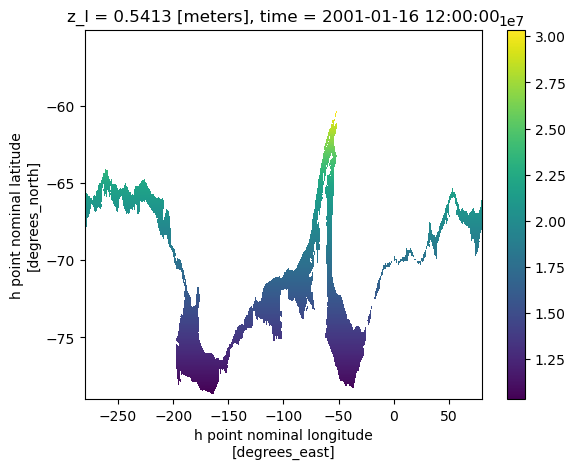

In [13]:
# Checking area and shelf mask
areaC_corr.plot()

### Bottom mask

In [14]:
bottom_mask_saltC = saltC.where(~np.isfinite(saltC.shift({'z_l': -1})))
bottom_mask_saltC = ~np.isnan(bottom_mask_saltC)

In [15]:
bottom_mask_saltM = saltM.where(~np.isfinite(saltM.shift({'z_l': -1})))
bottom_mask_saltM = ~np.isnan(bottom_mask_saltM)

In [16]:
botsalt_cont = saltC.where(bottom_mask_saltC).sum(dim='z_l')
botsalt_pert = saltM.where(bottom_mask_saltM).sum(dim='z_l')

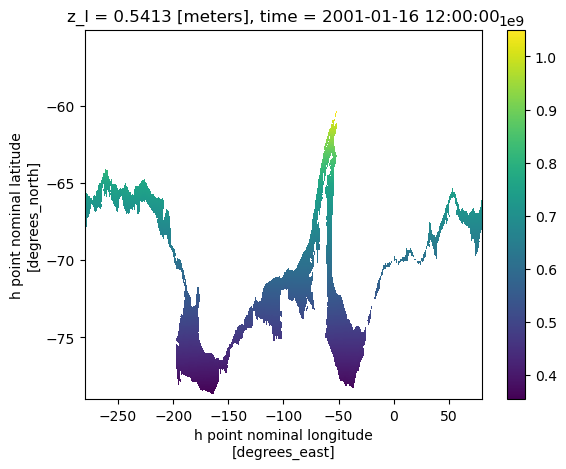

In [17]:
# Checking mask
(areaC_corr * botsalt_cont.isel(time=0)).plot()

### Time series

In [18]:
# Restricting to regions
botsalt_cont_1 = botsalt_cont.sel(xh=lon_slice_1)
botsalt_pert_1 = botsalt_pert.sel(xh=lon_slice_1)

botsalt_cont_2 = botsalt_cont.sel(xh=lon_slice_2)
botsalt_pert_2 = botsalt_pert.sel(xh=lon_slice_2)

botsalt_cont_3 = botsalt_cont.sel(xh=lon_slice_3)
botsalt_pert_3 = botsalt_pert.sel(xh=lon_slice_3)

botsalt_cont_4 = botsalt_cont.sel(xh=lon_slice_4)
botsalt_pert_4 = botsalt_pert.sel(xh=lon_slice_4)

botsalt_cont_5 = botsalt_cont.sel(xh=lon_slice_5)
botsalt_pert_5 = botsalt_pert.sel(xh=lon_slice_5)

botsalt_cont_6 = botsalt_cont.sel(xh=lon_slice_6)
botsalt_pert_6 = botsalt_pert.sel(xh=lon_slice_6)

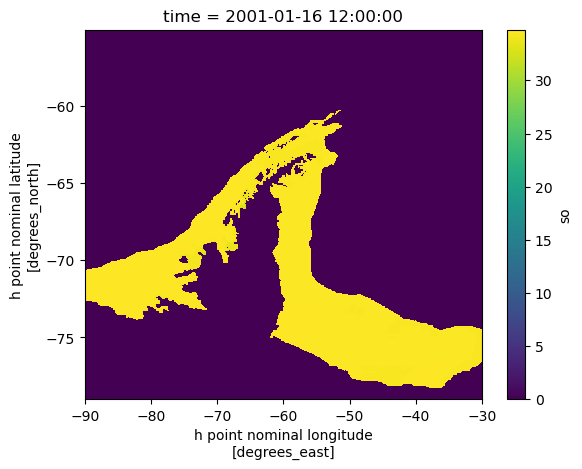

In [19]:
botsalt_cont_1.isel(time=0).plot()

In [20]:
# Spatial averages
botsalt_cont_1_time = (areaC_corr * botsalt_cont_1).sum(['xh', 'yh']) / areaC_corr.sel(xh=lon_slice_1).sum(['xh', 'yh'])
botsalt_pert_1_time = (areaM_corr * botsalt_pert_1).sum(['xh', 'yh']) / areaM_corr.sel(xh=lon_slice_1).sum(['xh', 'yh'])

botsalt_cont_2_time = (areaC_corr * botsalt_cont_2).sum(['xh', 'yh']) / areaC_corr.sel(xh=lon_slice_2).sum(['xh', 'yh'])
botsalt_pert_2_time = (areaM_corr * botsalt_pert_2).sum(['xh', 'yh']) / areaM_corr.sel(xh=lon_slice_2).sum(['xh', 'yh'])

botsalt_cont_3_time = (areaC_corr * botsalt_cont_3).sum(['xh', 'yh']) / areaC_corr.sel(xh=lon_slice_3).sum(['xh', 'yh'])
botsalt_pert_3_time = (areaM_corr * botsalt_pert_3).sum(['xh', 'yh']) / areaM_corr.sel(xh=lon_slice_3).sum(['xh', 'yh'])

botsalt_cont_4_time = (areaC_corr * botsalt_cont_4).sum(['xh', 'yh']) / areaC_corr.sel(xh=lon_slice_4).sum(['xh', 'yh'])
botsalt_pert_4_time = (areaM_corr * botsalt_pert_4).sum(['xh', 'yh']) / areaM_corr.sel(xh=lon_slice_4).sum(['xh', 'yh'])

botsalt_cont_5_time = (areaC_corr * botsalt_cont_5).sum(['xh', 'yh']) / areaC_corr.sel(xh=lon_slice_5).sum(['xh', 'yh'])
botsalt_pert_5_time = (areaM_corr * botsalt_pert_5).sum(['xh', 'yh']) / areaM_corr.sel(xh=lon_slice_5).sum(['xh', 'yh'])

botsalt_cont_6_time = (areaC_corr * botsalt_cont_6).sum(['xh', 'yh']) / areaC_corr.sel(xh=lon_slice_6).sum(['xh', 'yh'])
botsalt_pert_6_time = (areaM_corr * botsalt_pert_6).sum(['xh', 'yh']) / areaM_corr.sel(xh=lon_slice_6).sum(['xh', 'yh'])


In [21]:
# Check shape
botsalt_cont_1_time

<xarray.DataArray (time: 120)> Size: 480B
dask.array<truediv, shape=(120,), dtype=float32, chunksize=(2,), chunktype=numpy.ndarray>
Coordinates:
    z_l      float64 8B 0.5413
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00

In [27]:
botsalt_cont_1_time = botsalt_cont_1_time.load()
botsalt_pert_1_time = botsalt_pert_1_time.load()

In [28]:
botsalt_cont_2_time = botsalt_cont_2_time.load()
botsalt_pert_2_time = botsalt_pert_2_time.load()

In [29]:
botsalt_cont_3_time = botsalt_cont_3_time.load()
botsalt_pert_3_time = botsalt_pert_3_time.load()

In [22]:
botsalt_cont_4_time = botsalt_cont_4_time.load()
botsalt_pert_4_time = botsalt_pert_4_time.load()

In [23]:
botsalt_cont_5_time = botsalt_cont_5_time.load()
botsalt_pert_5_time = botsalt_pert_5_time.load()

In [24]:
botsalt_cont_6_time = botsalt_cont_6_time.load()
botsalt_pert_6_time = botsalt_pert_6_time.load()

In [33]:
botsalt_anom_1_time = botsalt_pert_1_time - botsalt_cont_1_time
botsalt_anom_1_time = botsalt_anom_1_time.load()
botsalt_anom_1_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_s1_pan01.nc')

In [34]:
botsalt_anom_2_time = botsalt_pert_2_time - botsalt_cont_2_time
botsalt_anom_2_time = botsalt_anom_2_time.load()
botsalt_anom_2_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_s2_pan01.nc')

In [36]:
botsalt_anom_3_time = botsalt_pert_3_time - botsalt_cont_3_time
botsalt_anom_3_time = botsalt_anom_3_time.load()
botsalt_anom_3_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_s3_pan01.nc')

In [26]:
botsalt_anom_4_time = botsalt_pert_4_time - botsalt_cont_4_time
botsalt_anom_4_time = botsalt_anom_4_time.load()
botsalt_anom_4_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_s4_pan01.nc')

In [27]:
botsalt_anom_5_time = botsalt_pert_5_time - botsalt_cont_5_time
botsalt_anom_5_time = botsalt_anom_5_time.load()
botsalt_anom_5_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_s5_pan01.nc')

In [28]:
botsalt_anom_6_time = botsalt_pert_6_time - botsalt_cont_6_time
botsalt_anom_6_time = botsalt_anom_6_time.load()
botsalt_anom_6_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_s6_pan01.nc')

#### Plotting all

Text(0.5, 1.0, 'Pan01 Time Series of Bottom Salinity on Shelf, Sector regions')

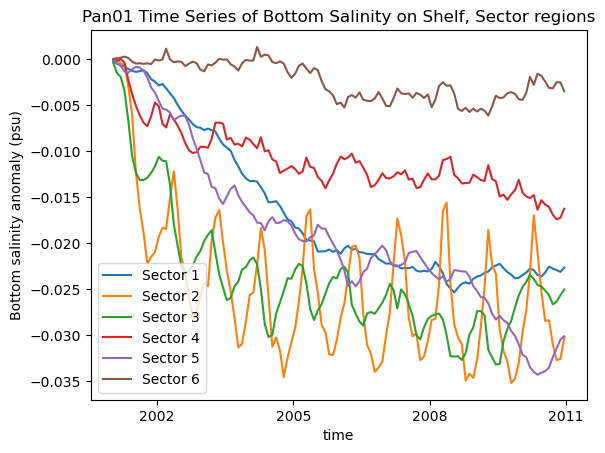

In [40]:
botsalt_anom_1_time.plot(label="Sector 1")
botsalt_anom_2_time.plot(label="Sector 2")
botsalt_anom_3_time.plot(label="Sector 3")
botsalt_anom_4_time.plot(label="Sector 4")
botsalt_anom_5_time.plot(label="Sector 5")
botsalt_anom_6_time.plot(label="Sector 6")
plt.ylabel("Bottom salinity anomaly (psu)")
plt.legend(loc="lower left")
plt.title("Pan01 Time Series of Bottom Salinity on Shelf, Sector regions")
